In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import HistGradientBoostingRegressor

In [13]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

# Inspection function
def inspect_df(df, name):
    print(f"--- {name} ---")
    print(df.head())
    print(df.info())
    print(df.isnull().sum())
    print("\n")

inspect_df(train, "Train")
inspect_df(test, "Test")
inspect_df(features, "Features")
inspect_df(stores, "Stores")

--- Train ---
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


--- Test ---
   Store  Dept        Date  IsHoliday
0      1     1  2012-11

In [32]:
# 2. Date Conversion
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# 3. Merge
# Using left join to ensure we keep all train records
df = train.merge(stores, on='Store', how='left').merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Markdown handling
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

# 5. Lags and Rolling Averages
# Ensure sorting before shifting
df = df.sort_values(by=['Store', 'Dept', 'Date'])
df['Lag1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df['Lag2'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
df['Rolling_Mean_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(window=4).mean())

# Fill NaNs from shift
df.fillna(0, inplace=True)

# 6. Encoding
df['IsHoliday'] = df['IsHoliday'].astype(int)
df = pd.get_dummies(df, columns=['Type'], prefix='Type')

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown4,MarkDown5,CPI,Unemployment,Lag1,Lag2,Rolling_Mean_4,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,0,151315,42.31,2.572,0.0,0.0,...,0.0,0.0,211.096358,8.106,0.00,0.00,0.00,True,False,False
1,1,1,2010-02-12,46039.49,1,151315,38.51,2.548,0.0,0.0,...,0.0,0.0,211.242170,8.106,24924.50,0.00,0.00,True,False,False
2,1,1,2010-02-19,41595.55,0,151315,39.93,2.514,0.0,0.0,...,0.0,0.0,211.289143,8.106,46039.49,24924.50,0.00,True,False,False
3,1,1,2010-02-26,19403.54,0,151315,46.63,2.561,0.0,0.0,...,0.0,0.0,211.319643,8.106,41595.55,46039.49,0.00,True,False,False
4,1,1,2010-03-05,21827.90,0,151315,46.50,2.625,0.0,0.0,...,0.0,0.0,211.350143,8.106,19403.54,41595.55,32990.77,True,False,False


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           421570 non-null  int64         
 1   Dept            421570 non-null  int64         
 2   Date            421570 non-null  datetime64[ns]
 3   Weekly_Sales    421570 non-null  float64       
 4   IsHoliday       421570 non-null  int64         
 5   Size            421570 non-null  int64         
 6   Temperature     421570 non-null  float64       
 7   Fuel_Price      421570 non-null  float64       
 8   MarkDown1       421570 non-null  float64       
 9   MarkDown2       421570 non-null  float64       
 10  MarkDown3       421570 non-null  float64       
 11  MarkDown4       421570 non-null  float64       
 12  MarkDown5       421570 non-null  float64       
 13  CPI             421570 non-null  float64       
 14  Unemployment    421570 non-null  flo

Text(0, 0.5, 'Average Weekly Sales')

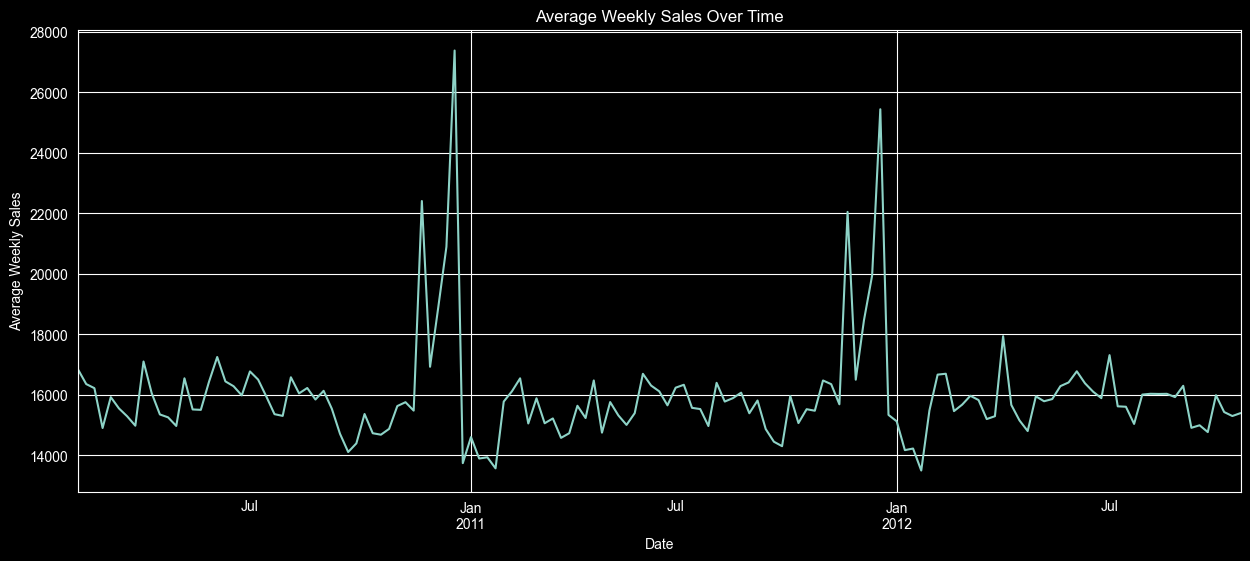

In [33]:
# EDA part 1: Trends over time
plt.figure(figsize=(15, 6))
df.groupby('Date')['Weekly_Sales'].mean().plot()

plt.title('Average Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')

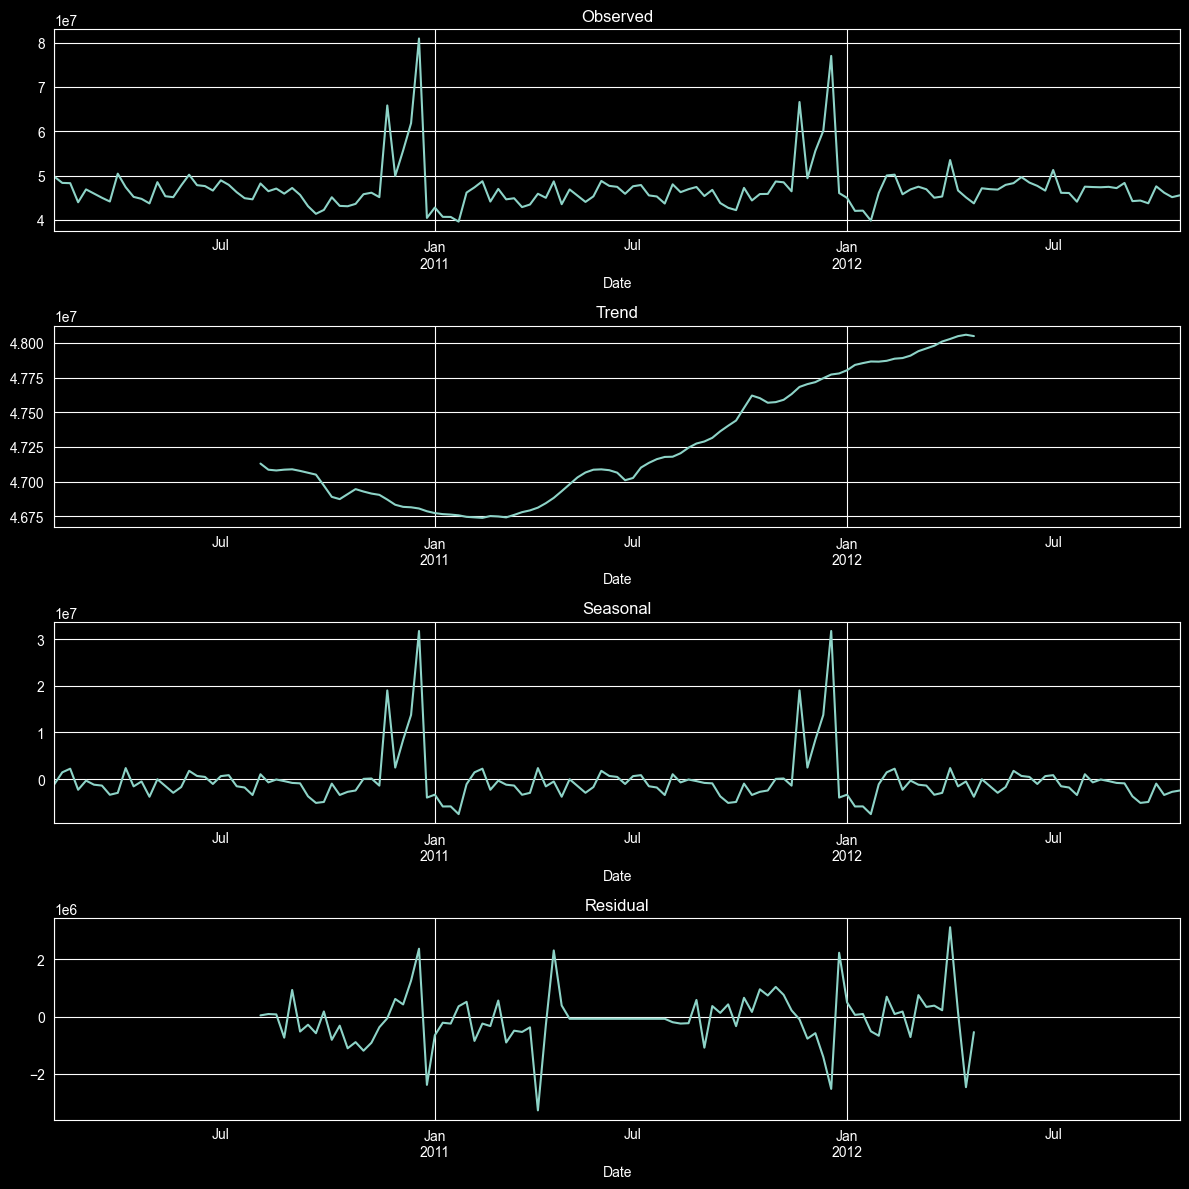

In [28]:
# B. Seasonal Decomposition
ts_data = df.groupby('Date')['Weekly_Sales'].sum()
result = seasonal_decompose(ts_data, model='additive', period=52)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()

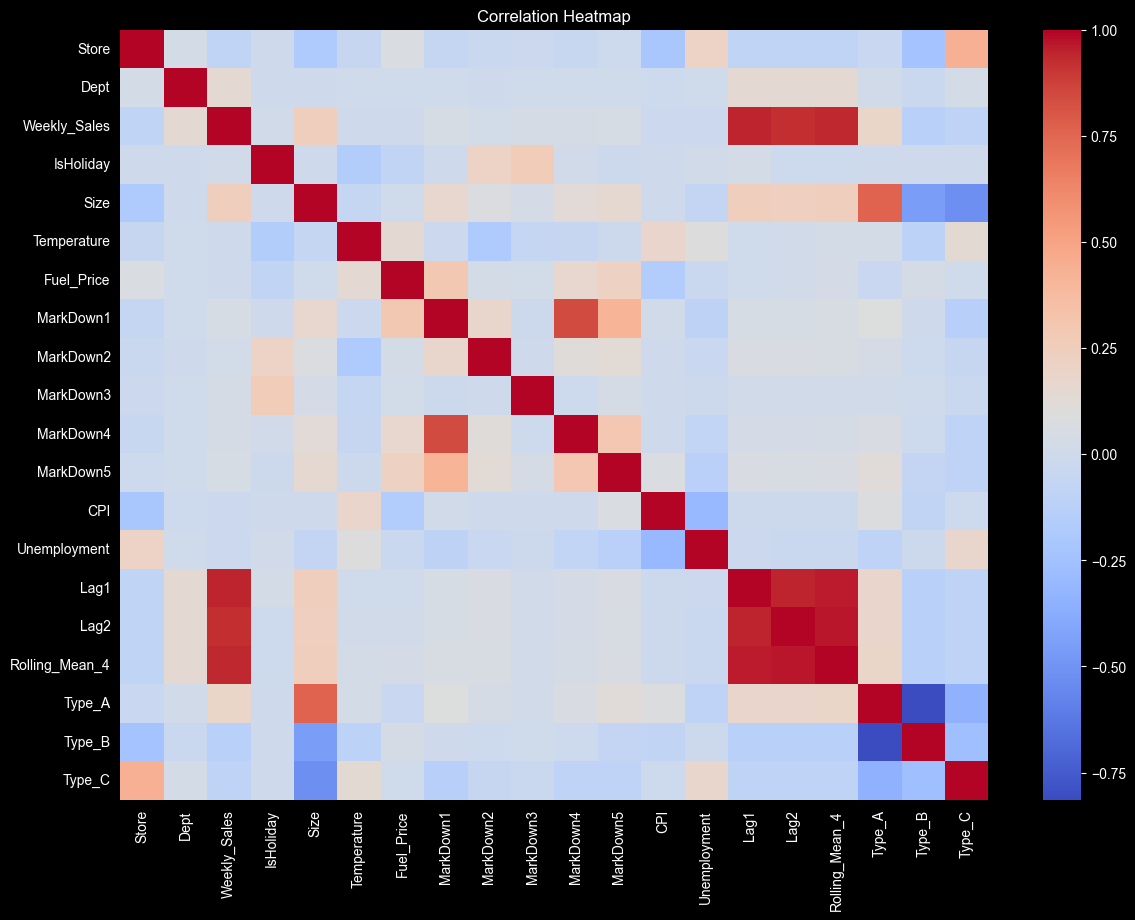

In [29]:
# C. Correlation Matrix
plt.figure(figsize=(14, 10))
corr_matrix = df.drop(columns=['Date']).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_matrix.png')